<a href="https://colab.research.google.com/github/ZhangTaTa/keras_learning/blob/master/img_cls_transfer_artic_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【数据格式】

本代码原始数据为上传至Google drive的jpg图片。

preprocess_image和preprocess_image_dir函数可完成图片/文件夹内图片的加载。配合K.constant函数，生成可进入神经网络的张量。

In [ ]:
import numpy as np
import keras
from keras.applications import vgg19

np.random.seed(1337)  # for reproducibility

Using TensorFlow backend.


加载数据

In [ ]:
"""
单图片风格版
"""

from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = './drive/My Drive/DLdata/img/zhongguohua/1143.jpg'
# This is the path to the style image.
style_reference_image_path = './drive/My Drive/DLdata/img/youhua/20.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [ ]:
"""
多图片风格版
修改style sample路径
"""

from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = './drive/My Drive/DLdata/img/zhongguohua/1143.jpg'
# This is the path to the style image.
# 考虑到纹理迁移对style图片风格统一性要求较高，style sample需经过筛选
style_reference_image_path = './drive/My Drive/DLdata/img/youhua'

# Dimensions of the generated picture.
style_num = 5
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

对将要进出VGG19 convnet的图像的预处理

In [ ]:
"""
单图片风格版
"""

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)   # vgg19.preprocess_input 的作用是减去 ImageNet 的平均像素值，使其中心为0
    return img

def deprocess_image(x):   # 相当于preprocess的逆操作
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
"""
多图片风格版
增加路径内图片预处理
"""

import os

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)   # vgg19.preprocess_input 的作用是减去 ImageNet 的平均像素值，使其中心为0
    return img

def preprocess_image_dir(dir_path):
  img = np.array([])
  image_list = os.listdir(dir_path)
  i = 0
  for image_path in image_list:
    single_img_path = os.path.join(dir_path,image_path)
    single_img = preprocess_image(single_img_path)
    if img.shape[0] == 0:
      img = preprocess_image(single_img_path)
    else:
      img = np.concatenate((img, preprocess_image(single_img_path)), axis=0)
    # 考虑内存，目前阶段只取前5个作为style sample
    print(single_img_path)
    i = i + 1
    if i >= style_num:
      break
  return img

def deprocess_image(x):   # 相当于preprocess的逆操作
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
"""
测试用
"""

img_style = preprocess_image_dir(style_reference_image_path)
print(img_style.shape)

./drive/My Drive/DLdata/img/youhua/350.jpg
(1, 400, 747, 3)


建立VGG19网络
需要输入三类图像作为批处理：样式参考图像，目标图像和将包含生成的图像的占位符。
占位符只是一个符号张量，其值通过Numpy数组从外部提供。样式参考和目标图像是静态的，因此使用K.constant进行定义，而包含在所生成图像的占位符中的值将随时间变化。

In [ ]:
"""
单图片风版
"""

from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))    # contant能创建一个张量
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))    # 实例化一个占位符

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)   # 拼接层（张量）

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

"""
结合batch特点，把target、style、combination一起输入的目的，是得到三者的feature（在一个张量里）
"""

print('Model loaded.')
print(type(input_tensor))

Model loaded.
<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
"""
多图片风格版
style用dirpreprocess处理
"""


from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))    # contant能创建一个张量
style_reference_image = K.constant(preprocess_image_dir(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))    # 实例化一个占位符

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)   # 拼接层（张量）

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

"""
结合batch特点，把target、style、combination一起输入的目的，是得到三者的feature（在一个张量里）
"""

print('Model loaded.')
print(type(input_tensor))

./drive/My Drive/DLdata/img/youhua/350.jpg
./drive/My Drive/DLdata/img/youhua/353.jpg
./drive/My Drive/DLdata/img/youhua/351.jpg
./drive/My Drive/DLdata/img/youhua/352.jpg
./drive/My Drive/DLdata/img/youhua/354.jpg
Model loaded.
<class 'tensorflow.python.framework.ops.Tensor'>


定义content loss

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

定义style loss

In [ ]:
"""
单图片风格版
"""

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
"""
多图片风格版
style sample feature求均值
"""

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))    # permute_dimensions重新排列张量的轴
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    style = K.mean(style, axis=0)
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    print(S)
    print(C)
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
"""
多图片风格版
另一种方法：每个style sample的loss求均值
但在报bug
"""

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))    # permute_dimensions重新排列张量的轴
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    channels = 3
    size = img_height * img_width
    C = K.expand_dims(gram_matrix(combination_features), axis=0)
    for style_loss_i in range(0, style_num):
      single_style = style[style_loss_i, :, :, :]
      if style_loss_i == 0:
        S = K.expand_dims(gram_matrix(single_style), axis=0)
      else:
        S = K.concatenate((S, K.expand_dims(gram_matrix(single_style), axis=0)), axis=0)
        C = K.concatenate((C, K.expand_dims(gram_matrix(combination_features), axis=0)), axis = 0)
    loss = K.sum(K.mean(K.square(S - C), axis=0)) / (4. * (channels ** 2) * (size ** 2))
    return loss

正则化损失，增加生成图片的空间连续性，避免过度像素化

In [ ]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

layer、权重（weight）、损失（loss）设置。
调整content_weight以调整target图片特征比重

In [ ]:
"""
单图片风格版
"""

# Dict mapping layer names to activation tensors 将层的名称映射为激活张量的字典
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'    # 最顶层的
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']   # 底层的几个
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025   # 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)   # 在定义损失时将所有分量添加到这个标量变量中
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [ ]:
"""
多图片风格版
注意每种图片所在的位置
"""

# Dict mapping layer names to activation tensors 将层的名称映射为激活张量的字典
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'    # 最顶层的
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']   # 底层的几个
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025   # 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)   # 在定义损失时将所有分量添加到这个标量变量中
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]    
combination_features = layer_features[1 + style_num, :, :, :]   
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:   # 每个风格层的风格损失，取平均值
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1:style_num + 1, :, :, :]
    combination_features = layer_features[1 + style_num, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

梯度下降

> Evaluator类的意义：


这里使用了L-BFGS算法，而L-BFGS算法与SciPy打包在一起。但SciPy有一些缺陷：

1.   需要将损耗函数的值和梯度的值作为两个单独的函数传递。
2.   它只能应用于平面向量，而我们具有3D图像阵列。

对我们来说，独立地计算损失函数的值和梯度的值将是非常低效的，因为这将导致两者之间的大量冗余计算。我们将比联合计算它们慢将近两倍。

为了绕过这个问题，我们设置了一个名为Evaluator的Python类，该类将立即计算损耗值和渐变值，在首次调用时将返回损耗值，并将缓存渐变用于下一次调用。

In [ ]:
# Get the gradients of the generated image wrt the loss
# 获取损失相对于生成图像的梯度
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
# 用于获取当前损失值和当前梯度值
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


# 这个类将 fetch_loss_and_grads 包装起来，让你可以利用两个单独的方法调用来获取损失和梯度，这是我们要使用的 SciPy 优化器所要求的
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

L - BFGS算法 运行梯度上升

In [ ]:
"""
单图片风格版
"""

from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
import time

result_prefix = './drive/My Drive/DLdata/style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()    # scipy.optimize.fmin_l_bfgs_b 只能处理展平的向量
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

In [ ]:
"""
多图片风格版
"""

from scipy.optimize import fmin_l_bfgs_b
from imageio import imwrite
import time

result_prefix = './drive/My Drive/DLdata/style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()    # scipy.optimize.fmin_l_bfgs_b 只能处理展平的向量
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2194798300.0
Image saved as ./drive/My Drive/DLdata/style_transfer_result_at_iteration_0.png
Iteration 0 completed in 30s
Start of iteration 1
Current loss value: 1509239900.0
Image saved as ./drive/My Drive/DLdata/style_transfer_result_at_iteration_1.png
Iteration 1 completed in 25s
Start of iteration 2
Current loss value: 1390344000.0
Image saved as ./drive/My Drive/DLdata/style_transfer_result_at_iteration_2.png
Iteration 2 completed in 25s
Start of iteration 3
Current loss value: 1335372800.0
Image saved as ./drive/My Drive/DLdata/style_transfer_result_at_iteration_3.png
Iteration 3 completed in 26s
Start of iteration 4
Current loss value: 1308089500.0
Image saved as ./drive/My Drive/DLdata/style_transfer_result_at_iteration_4.png
Iteration 4 completed in 26s
Start of iteration 5
Current loss value: 1290191200.0
Image saved as ./drive/My Drive/DLdata/style_transfer_result_at_iteration_5.png
Iteration 5 completed in 26s
Start of iteration 6
C

展示图片

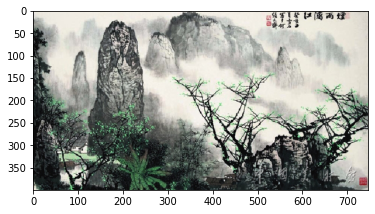

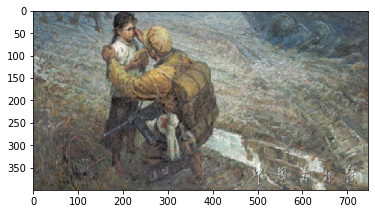

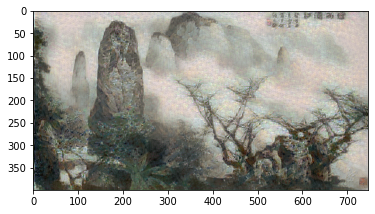

In [ ]:
"""
单张风格图片
"""

from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()

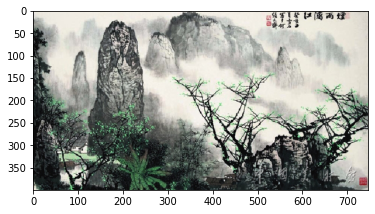

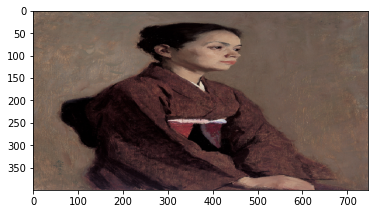

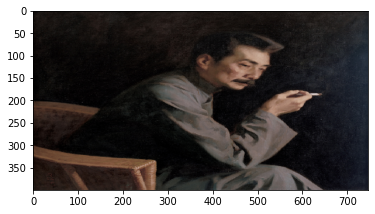

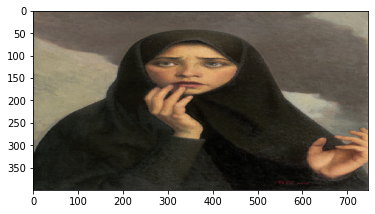

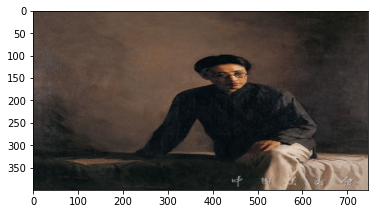

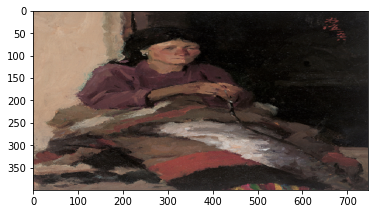

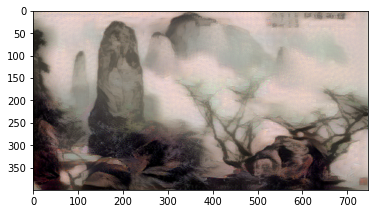

In [ ]:
"""
多张风格图片
"""

from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
image_list = os.listdir(style_reference_image_path)
i = 0
for image_path in image_list:
    single_img_path = os.path.join(style_reference_image_path,image_path)
    plt.imshow(load_img(single_img_path, target_size=(img_height, img_width)))
    plt.figure()
    i = i + 1
    if i >= style_num:
      break

# Generate image
plt.imshow(img)
plt.show()

文献查阅，公式；
既然能transfer style，那么为什能？找style量化方式